# Análisis de resultados
El experimento consta de desplegar 3 instancias de un microservicio que ante una suma de dos operandos y un resultado debe contestar si el resultado es correcto o no (es decir calificar una pregunta). Cada microservicio tiene una probabilidad de falla. Realizaremos 3 simulaciones con 3 probabilidades distintas de falla así:

1. prob_falla = 0.5%
2. prob_falla = 1%
3. prob_falla = 5%

En cada simulación se correrá un ciclo con 10,000 iteraciones en donde en cada iteración el componente validador se encargará de enviar una petición a los 3 microservicios, recibir las respuestas (True o False) y compararlas. Si existe discrepancia en las respuestas, el componente validador determinará que el microservicio que contesta diferente presenta una falla.

Detengamonos un poco a analizar los posibles resultados que pueden presentarse en cada iteración:

| escenario | server_1 | server_2 | server_3 | falla_según_validador | notes |
|-----------|----------|----------|----------|-----------------------|---------------|
|     1     | no falla | no falla | no falla | ninguno               | Todos contestan igual y la respuesta es correcta|
|     2     | no falla | no falla | falla    | server_3              | La respuesta del servidor 3 es incorrecta y diferente a las demás |
|     3     | no falla | falla    | no falla | server_2              | La respuesta del servidor 2 es incorrecta y diferente a las demás |
|     4     | falla    | no falla | no falla | server_1              | La respuesta del servidor 1 es incorrecta y diferente a las demás |
|     5     | falla    | falla    | no falla | server_3              | La respuesta del servidor 3 es correcta y diferente a las demás   |
|     6     | falla    | no falla | falla    | server_2              | La respuesta del servidor 2 es correcta y diferente a las demás   |
|     7     | no falla | falla    | falla    | server_1              | La respuesta del servidor 1 es correcta y diferente a las demás   |
|     8     | falla    | falla    | falla    | ninguno               | Todos contestan igual y la respuesta es incorrecta                |

Nótese como en los escenarios 2 a 8 se presenta una falla en alguno, algunos o todos los componentes pero solo en los escenarios 2, 3 y 4 el componente validador es acertado en su dictámen. En los escenarios 5, 6 y 7, el componente validador erróneamente determinó que estaba fallando un componente que estaba funcionando de manera correcta y no se dió cuenta que los otros dos estaban fallando. El escenario 8 es aún más grave, ya que los 3 estaban fallando y se determinó que ninguno fallaba. Para nuestro análisis nos interesa conocer del número total de fallas (escenarios 2 a 8), cuales fallas fueron detectadas correctamente (escenarios 2, 3, y 4). Con lo anterior somos capaces de determinar el porcentaje de fallas que nuestro validador es capaz de detectar correctamente y así validar nuestra hipótesis de diseño.
   
Vamos a analizar los resultados obtenidos con la ayuda de la librería pandas y un poco de teoría de probabilidad.


### Importamos las librerías

In [5]:
import pandas as pd
import numpy as np

## Experimento #1: prob_falla = 1%

### Cargamos los datos del archivo csv a un dataframe de pandas e imprimimos las 5 primeras filas

In [36]:
path_to_data_file = './experimento.csv'
df = pd.read_csv(path_to_data_file)
df['unavailable_server'] = df['unavailable_server'].fillna(-1).astype(int).replace(-1, 'None')
df.head()

,operand_1,operand_2,query_result,server_1_response,server_2_response,server_3_response,unavailable_server
0,2,2,4,True,True,True,None
1,3,3,6,True,True,False,3
2,5,5,10,False,False,True,3
3,2,3,4,False,False,False,None
4,4,4,8,True,True,True,None


### Calculamos el resultado correcto de cada operación o pregunta

In [37]:
df['actual_result'] = df['operand_1'] + df['operand_2']

In [38]:
df.head()

,operand_1,operand_2,query_result,server_1_response,server_2_response,server_3_response,unavailable_server,actual_result
0,2,2,4,True,True,True,None,4
1,3,3,6,True,True,False,3,6
2,5,5,10,False,False,True,3,10
3,2,3,4,False,False,False,None,5
4,4,4,8,True,True,True,None,8


### Determinamos la respuesta correcta que debío enviar el servidor

In [39]:
df['expected_server_response'] = df.apply(lambda row: True if row['query_result'] == row['actual_result'] else False, axis=1)
df

,operand_1,operand_2,query_result,server_1_response,server_2_response,server_3_response,unavailable_server,actual_result,expected_server_response
0,2,2,4,True,True,True,None,4,True
1,3,3,6,True,True,False,3,6,True
2,5,5,10,False,False,True,3,10,True
3,2,3,4,False,False,False,None,5,False
4,4,4,8,True,True,True,None,8,True
5,5,3,9,True,True,False,3,8,False
6,3,4,7,False,True,True,1,7,True
7,9,10,15,False,True,False,2,19,False
8,2,2,5,True,True,True,None,4,False


### Calificamos la veracidad del validador
A continuación vamos a etiquetar cada fila individual de nuestros datos así:

* **true_positive**: Corresponde a aquel caso en el que nuestro validador detectó correctamente cuando un microservicio estaba fallando. Por ejemplo ante la consulta 2 + 2 = 4,  dos de los microservicios contestaron que era correcta, uno contestó que era incorrecta y por consiguiente el validador detectó correctamente que el que contestó diferente estaba fallando. 
* **true_negative**: Corresponde a aquel caso en el que nuestro validador detectó que todos nuestros microservicios estaban funcionando correctamente. Por ejemplo ante la consulta 2 + 2 = 4, los tres microservicios contestaron que era correcta y el validador detectó que ninguno fallaba. 
* **false_positive**: Corresponde a aquel caso en el que nuestro validador detectó que un microservicio estaba fallando y en realidad estaba funcionando correctamente. Por ejemplo ante la consulta 2 + 2 = 4,  dos de los microservicios contestaron que era incorrecta, uno contestó que era correcta y por consiguiente el validador detectó erróneamente que el que contestó diferente estaba fallando. 
* **false_negative**: Corresponde a aquel caso en el que nuestro validador no detectó que un microservicio estaba fallando. Por ejemplo ante la consulta 2 + 2 = 4,  los 3 microservicios contestaron que era incorrecta y por consiguiente el validador detectó erróneamente que no existía falla alguna.

Es de aclarar que se podría argumentar que un falso positivo también implica un falso negativo; por ejemplo, si ante la consulta (2 + 2) == 4, dos microservicios contestan que es incorrecta y uno contesta que es correcta, el validador habrá identificado erróneamente (falso positivo) que el servicio que contestó diferente está fallando cuando no lo está, y a su vez no habría detectado que los que contestaron de forma incorrecta estaban fallando (falsos negativos). Sin embargo, este caso lo vamos a etiquetar como falso positivo para simplificar el análisis.

Teniendo en cuenta lo que acabamos de ver podemos actualizar la tabla que se presentó al inicio de este documento:

| escenario | server_1 | server_2 | server_3 | falla_según_validador | label | 
|-----------|----------|----------|----------|-----------------------|---------------|
|     1     | no falla | no falla | no falla | ninguno               | true_negative |
|     2     | no falla | no falla | falla    | server_3              | true_positive |
|     3     | no falla | falla    | no falla | server_2              | true_positive |
|     4     | falla    | no falla | no falla | server_1              | true_positive |
|     5     | falla    | falla    | no falla | server_3              | false_positive  |
|     6     | falla    | no falla | falla    | server_2              | false_positive  |
|     7     | no falla | falla    | falla    | server_1              | false_positive  |
|     8     | falla    | falla    | falla    | ninguno               | false_negative             |

Recordemos que estamos interesados en los escenarios 2 a 8 ya que estos son aquellos escenarios en donde existe por lo menos una falla.

In [62]:
def label_validator(row):
    server_responses = {
        1: row['server_1_response'],
        2: row['server_2_response'],
        3: row['server_3_response']
    }

    expected_server_response = row['expected_server_response']
    validator_unavailability_resolution = row['unavailable_server']

    if validator_unavailability_resolution == 'None':
        if all(res == expected_server_response for res in server_responses.values()):
            return 'true_negative'
        elif all(res != expected_server_response for res in server_responses.values()):
            return 'false_negative'
    elif server_responses[validator_unavailability_resolution] == expected_server_response:
        return 'false_positive'
    elif server_responses[validator_unavailability_resolution] != expected_server_response:
        return 'true_positive'
    
df['label'] = df.apply(label_validator, axis=1)
df = df[['server_1_response', 'server_2_response', 'server_3_response', 'unavailable_server', 'expected_server_response', 'label']]
df.head()
    

,server_1_response,server_2_response,server_3_response,unavailable_server,expected_server_response,label
0,True,True,True,None,True,true_negative
1,True,True,False,3,True,true_positive
2,False,False,True,3,True,false_positive
3,False,False,False,None,False,true_negative
4,True,True,True,None,True,true_negative


Agrupemos el dataframe por la columna label y contemos:

In [63]:
by_label = df.groupby('label')
label_counts = by_label.size()
label_counts

label
false_negative    1
false_positive    2
true_negative     3
true_positive     3
dtype: int64

Calculamos el porcentaje de veces que detectamos correctamente la falla:

In [64]:
false_positive_count = label_counts.get('false_positive', 0)
true_positive_count = label_counts.get('true_positive', 0)
false_negative_count = label_counts.get('false_negative', 0)

if (false_positive_count + false_negative_count + true_positive_count) != 0:
    proportion = true_positive_count / (false_positive_count + false_negative_count + true_positive_count) 
else:
    proportion = 0
proportion

0.5

Lo anterior significa que nuestro componente validador en nuestro experimento logró detectar correctamente el 50% de las fallas que se presentaron.

### Análisis de probabilidad

Revisemos un poco de teoría de probabilidad y corroboremos si los resultados obtenidos por el experimento están acordes a la teoría.

Definimos,

$P_1 = 0.01$ *(Probabilidad de que el servidor 1 falle)*

$P_2 = 0.01$ *(Probabilidad de que el servidor 2 falle)*

$P_3 = 0.01$ *(Probabilidad de que el servidor 3 falle)*


Así mismo definimos,

$1-P_1 = 0.99$ *(Probabilidad de que el servidor 1 no falle)*

$1-P_2 = 0.99$ *(Probabilidad de que el servidor 2 no falle)*

$1-P_3 = 0.99$ *(Probabilidad de que el servidor 3 no falle)*


Definimos también la probabilidad de que al menos uno de los componentes falle (escenarios 2 a 8) como,

$P_f = 1-(1-P_1)*(1-P_2)*(1-P_3)$ *(Probabilidad de que al menos uno de los componentes falle)*


Recordemos que la suma de las probabilidades de ocurrencia de todos los escenarios o eventos posibles es igual a 1. Así mismo sabemos que la probabilidad de tener el escenario 1 es igual a $(1-P_1)*(1-P_2)*(1-P_3)$ *(Evento en el que ninguno de los componentes falla)*. Por consiguiente si a 1 le restamos la probabilidad de ocurrencia del escenario 1 habremos obtenido la probabilidad de que ocurra alguno de los escenarios 2 a 8 *(Por lo menos un componente falla)*


Podemos ir actualizando nuestra tabla de escenarios así:

| escenario | server_1 | server_2 | server_3 | falla_según_validador |     label      |  prob  | 
|-----------|----------|----------|----------|-----------------------|----------------|--------|
|     1     | no falla | no falla | no falla | ninguno               | true_negative  | $(1-P_1)*(1-P_2)*(1-P_3)$ | 
|     2     | no falla | no falla | falla    | server_3              | true_positive  | $(1-P_1)*(1-P_2)*P_3$ |
|     3     | no falla | falla    | no falla | server_2              | true_positive  | $(1-P_1)*P_2*(1-P_3)$ |
|     4     | falla    | no falla | no falla | server_1              | true_positive  | $P_1*(1-P_2)*(1-P_3)$ |
|     5     | falla    | falla    | no falla | server_3              | false_positive | $P_1*P_2*(1-P_3)$ |
|     6     | falla    | no falla | falla    | server_2              | false_positive | $P_1*(1-P_2)*P_3$ |
|     7     | no falla | falla    | falla    | server_1              | false_positive | $(1-P_1)*P_2*P_3$ |
|     8     | falla    | falla    | falla    | ninguno               | false_negative | $P_1*P_2*P_3$ |
|          **Total**          ||||||  $$\sum_{\text{escenario} = 1}^{8} = 1$$            |

Ahora nos interesa calcular la probabilidad de tener un true_positive dado que por lo menos uno de los componentes falla (Esto es la probabilidad de que en caso de una falla el componente validador sea capaz de detectarla correctamente). Lo anterior lo calculamos así:

$$
proportion = P(\text{true\_positive} \mid \text{falla}) = \frac{P(\text{true\_positive} \cap \text{falla})}{P_f}
$$

Nótese como $P(\text{true\_positive} \cap \text{falla})$ es justamente la suma de probabilidades de los escenarios 3, 4 y 5, entonces:
$$
proportion = P(\text{true\_positive} \mid \text{falla}) = \frac{(1-P_1)*(1-P_2)*P_3 + (1-P_1)*P_2*(1-P_3) + P_1*(1-P_2)*(1-P_3) }{P_f}
$$

$$
proportion = P(\text{true\_positive} \mid \text{falla}) = \frac{(0.99)*(0.99)*(0.01)*3}{1-(0.99)*(0.99)*(0.99)}
$$


In [70]:
proportion = (0.99*0.99*0.01*3)/(1-0.99*0.99*0.99)
proportion

0.9899666677889605

Con esto demostramos que los resultados de nuestro experimento son acordes a la teoría de probabilidad.

### Teoría de probabilidad aplicada a 5 y 7 microservicios

Revisemos ahora si podemos trasladar el anterior análisis a 5 o 7 microservicios. Para 3 microservicios vimos que se pueden presentar 8 escenarios. Lo anterior resulta de la ecuación de permutaciones, que no es otra cosa que el número de posibilidades *n* (falla - no falla) que se tienen para un número de elementos *k* (# de servidores): 

Para 3 servicios:
$$
n^k = 2^3 = 8
$$

Para 5 servicios:
$$
n^k = 2^5 = 32
$$


Para 7 servicios:
$$
n^k = 2^7 = 128
$$

La tabla para 8 escenarios fue sencilla de construir, pero para 32 o 128 escenarios es una tarea dificil; sin embargo, aún vamos a ser capaces de calcular la proporción. Veamos como.

Del experimento anterior podemos concluir que nuestro validador detecta fallas correctamente en los casos en el que el número de servicios que falla es minoría. Lo anterior debido a que si la minoría falla, el componente validador detecta una inconsistencia en las respuestas y toma la respuesta de la mayoría como la respuesta correcta, etiquetando así a la minoría como servicios que presentan fallas. Para 3 componentes teníamos detecciones de fallas correctas cuando 1 componente fallaba, pero teniamos detecciones de fallas incorrectas cuando 2 o 3 componentes fallaban.

| escenario | server_1 | server_2 | server_3 | falla_según_validador | label |  failing_servers |
|-----------|----------|----------|----------|-----------------------|---------------| ---------|
|     1     | no falla | no falla | no falla | ninguno               | true_negative |     0    |
|     2     | no falla | no falla | falla    | server_3              | **true_positive** |     **1**    |
|     3     | no falla | falla    | no falla | server_2              | **true_positive** |     **1**    |
|     4     | falla    | no falla | no falla | server_1              | **true_positive** |     **1**    |
|     5     | falla    | falla    | no falla | server_3              | false_positive  |     2    |
|     6     | falla    | no falla | falla    | server_2              | false_positive  |     2    |
|     7     | no falla | falla    | falla    | server_1              | false_positive  |     2    |
|     8     | falla    | falla    | falla    | ninguno               | false_negative             |     3    |


Entonces en el caso de 5 servicios, el validador detectará correctamente las fallas si 1 ó 2 servicios fallan; y en el caso de 7 servicios, el validador detectará correctamente las fallas si 1, 2 ó 3 servicios fallan. Con esto ya tenemos todo para construir nuestras probabilidades.

Hagamos las siguientea deficiones:

$P_i = 0.01$ *(Probabilidad de falla de 1 servicio)*

$(1-P_i) = 0.99$ *(Probabilidad de no falla de 1 servicio)*

$P_{nf} = 1 - (1-P_i)^n$ *(Probabiliad de que en n servicios falle al menos 1)*

Ahora vamos a apoyarnos en la fórmula de combinaciones, que no es otra cosa que la forma en que ese pueden seleccionar *k* elementos (número de servidores fallando) de un conjunto de *n* elementos (número total de servidores) sin tener en cuenta el órden.

$$
C(n,k) = \binom{n}{k} = \frac{n!}{k!(n-k)!}
$$

Para 3 servidores (nóte como obtenemos los mismos resultados que obtuvimos en la sección anterior, solo que esta vez repartidos en 4 escenarios y no en 8):

| comb | k | description | probs |  explanation |
|-----------|----------|----------|----------| ------- |
|      $\binom{3}{0}=1$    | $0$ | prob_0_falla | $\binom{3}{0}*(1-P_i)^{3-0}*P_i^0$ | Existe solo un escenario en el que ningún componente falla |
|      $\binom{3}{1}=3$     | $1$ | prob_1_falla| $\binom{3}{1}*(1-P_i)^{3-1}*P_i^1$    | Existen 3 escenarios en el que 1 componente falla |
|     $\binom{3}{2}=3$     | $2$ | prob_2_falla    | $\binom{3}{2}*(1-P_i)^{3-2}*P_i^2$ | Existen 3 escenarios en el que 2 componentes fallan |
|     $\binom{3}{3}=1$      | $3$    | prob_3_falla| $\binom{3}{3}*(1-P_i)^{3-3}*P_i^3$|  Existe solo un escenario en el que todos los componentes fallan | 
|          $Total=8$          ||| $$\sum_{\text{escenario} = 1}^{8} = 1$$            ||


Para 5 servidores:

| comb | k | description | probs |  explanation |
|-----------|----------|----------|----------| ------- |
|      $\binom{5}{0}=1$    | $0$ | prob_0_falla | $\binom{5}{0}*(1-P_i)^{5-0}*P_i^0$ | Existe solo un escenario en el que ningún componente falla |
|      $\binom{5}{1}=5$     | $1$ | prob_1_falla| $\binom{5}{1}*(1-P_i)^{5-1}*P_i^1$    | Existen 5 escenarios en el que 1 componente falla |
|     $\binom{5}{2}=10$     | $2$ | prob_2_falla    | $\binom{5}{2}*(1-P_i)^{5-2}*P_i^2$ | Existen 10 escenarios en el que 2 componentes fallan |
|     $\binom{5}{3}=10$      | $3$    | prob_3_falla| $\binom{5}{3}*(1-P_i)^{5-3}*P_i^3$| Existen 10 escenarios en el que 3 componentes fallan  |
|     $\binom{5}{4}=5$      | $4$    | prob_4_falla| $\binom{5}{4}*(1-P_i)^{5-4}*P_i^4$| Existen 5 escenarios en el que 4 componentes fallan  |
|     $\binom{5}{5}=1$      | $5$    | prob_5_falla| $\binom{5}{5}*(1-P_i)^{5-5}*P_i^5$|  Existe solo un escenario en el que todos los componentes fallan |
|          $Total=32$          ||| $$\sum_{\text{escenario} = 1}^{32} = 1$$            ||

Para 7 servidores:

| comb | k | description | probs |  explanation |
|-----------|----------|----------|----------| ------- |
|      $\binom{7}{0}=1$    | $0$ | prob_0_falla | $\binom{7}{0}*(1-P_i)^{7-0}*P_i^0$ | Existe solo un escenario en el que ningún componente falla |
|      $\binom{7}{1}=7$     | $1$ | prob_1_falla| $\binom{7}{1}*(1-P_i)^{7-1}*P_i^1$    | Existen 7 escenarios en el que 1 componente falla |
|     $\binom{7}{2}=21$     | $2$ | prob_2_falla    | $\binom{7}{2}*(1-P_i)^{7-2}*P_i^2$ | Existen 21 escenarios en el que 2 componentes fallan |
|     $\binom{7}{3}=35$      | $3$    | prob_3_falla| $\binom{7}{3}*(1-P_i)^{7-3}*P_i^3$| Existen 35 escenarios en el que 3 componentes fallan  |
|     $\binom{7}{4}=35$      | $4$    | prob_4_falla| $\binom{7}{4}*(1-P_i)^{7-4}*P_i^4$| Existen 35 escenarios en el que 4 componentes fallan  |
|     $\binom{7}{5}=21$      | $5$    | prob_5_falla| $\binom{7}{5}*(1-P_i)^{7-5}*P_i^5$|  Existen 21 escenarios en el que 5 componentes fallan |
|     $\binom{7}{6}=7$      | $6$    | prob_6_falla| $\binom{7}{6}*(1-P_i)^{7-6}*P_i^6$|  Existen 7 escenarios en el que 6 componentes fallan  |
|     $\binom{7}{7}=1$      | $7$    | prob_7_falla| $\binom{7}{7}*(1-P_i)^{7-7}*P_i^7$|  Existe solo un escenario en el que todos los componentes fallan |
|          $Total=128$          ||| $$\sum_{\text{escenario} = 1}^{128} = 1$$            ||

Con lo anterior ya podemos calcular las proporciones que buscamos:

Para 5 servidores:

$$
proportion_5 = P(\text{true\_positive} \mid \text{falla}) = \frac{P(\text{true\_positive} \cap \text{falla})}{ P_{nf} }
$$

Nótese como de nuevo $P(\text{true\_positive} \cap \text{falla})$ es justamente la suma de probabilidades de los escenarios en los que falla la minoría (1 y 2 servicios para el caso de 5 servicios)

$$
proportion_5 = P(\text{true\_positive} \mid \text{falla}) = \frac{\binom{5}{1}*(1-P_i)^{5-1}*P_i^1 + \binom{5}{2}*(1-P_i)^{5-2}*P_i^2}{ 1 - (1-P_i)^5 }
$$

Para 7 servidores:

$$
proportion_7 = P(\text{true\_positive} \mid \text{falla}) = \frac{\binom{7}{1}*(1-P_i)^{7-1}*P_i^1 + \binom{7}{2}*(1-P_i)^{7-2}*P_i^2 + \binom{7}{3}*(1-P_i)^{7-3}*P_i^3}{ 1 - (1-P_i)^7 }
$$




In [82]:
proportion_5 = (5 * (1-0.01)**(5-1)*(0.01)**1 + 10 * (1-0.01)**(5-2)*(0.01)**2) / (1-(1-0.01)**5)
proportion_5

0.9997990081609961

In [84]:
proportion_7 = (7 * (1-0.01)**(7-1)*(0.01)**1 + 21 * (1-0.01)**(7-2)*(0.01)**2 + 35 * (1-0.01)**(7-3)*(0.01)**3 ) / (1-(1-0.01)**7)
proportion_7

0.9999949706108803

Finalmente podemos derivar una función que dado un número de servidores y una probabilidad de falla de un servidor nos devuelva el porcentaje de fallas que el validador es capaz de detectar correctamente

In [92]:
from math import factorial
def get_percentage_of_detected_failures(num_servers: int, fail_prob: float) -> float:
    if num_servers % 2 == 0:
        return
    no_fail_prob = 1 - fail_prob
    at_least_1_fail_prob =  1 - (no_fail_prob) ** num_servers
    # calculate the number of servers that needs to fail in order for the validator to label a true_positive
    failing_servers_for_true_positive = num_servers // 2
    # calculate P(true_positive and failure)
    p_true_positive = 0
    for i in range(1, failing_servers_for_true_positive + 1):
        comb = factorial(num_servers)/(factorial(i)*factorial(num_servers-i))
        p_true_positive += comb * no_fail_prob ** (num_servers - i) * fail_prob ** i
    return p_true_positive / at_least_1_fail_prob

proportion_3 = get_percentage_of_detected_failures(3, 0.01)
proportion_5 = get_percentage_of_detected_failures(5, 0.01)
proportion_7 = get_percentage_of_detected_failures(7, 0.01)
print('servers: 3, fail_prob: 0,01', proportion_3)
print('servers: 5, fail_prob: 0,01', proportion_5)
print('servers: 7, fail_prob: 0,01', proportion_7)
    


servers: 3, fail_prob: 0,01 0.989966667788964
servers: 5, fail_prob: 0,01 0.9997990081609961
servers: 7, fail_prob: 0,01 0.9999949706108803


Grafiquemos los resultados para distintas probabilidades y 3, 5 y 7 servidores

In [98]:
# List of servers and probabilities
servers = [3, 5, 7]
probs = [0.005, 0.01, 0.05, 0.1, 0.2]

# Create a list to store the results
results = []

# Nested loop to calculate the percentage for each combination
for s in servers:
    for p in probs:
        results.append({
            'num_servers': s,
            'fail_prob': p,
            'proportion': get_percentage_of_detected_failures(s, p)
        })

# Convert the results list to a DataFrame
df = pd.DataFrame(results)

print(df)

    num_servers  fail_prob  proportion
0             3      0.005    0.994992
1             3      0.010    0.989967
2             3      0.050    0.949167
3             3      0.100    0.896679
4             3      0.200    0.786885
5             5      0.005    0.999950
6             5      0.010    0.999799
7             5      0.050    0.994881
8             5      0.100    0.979097
9             5      0.200    0.913851
10            7      0.005    0.999999
11            7      0.010    0.999995
12            7      0.050    0.999358
13            7      0.100    0.994771
14            7      0.200    0.957808


Finalmente podemos graficar los resultados

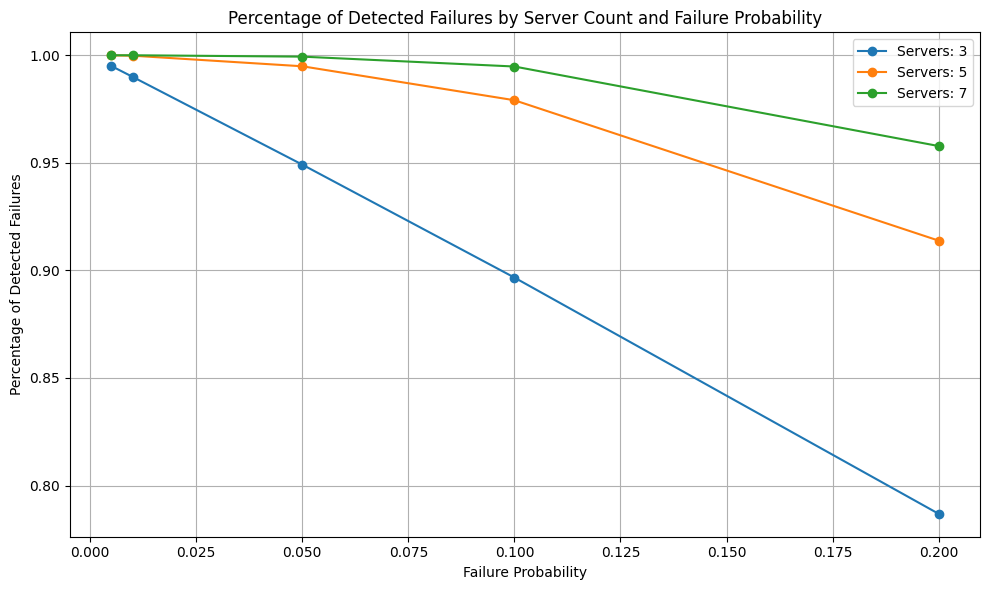

In [101]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

for s in servers:
    subset = df[df['num_servers'] == s]
    plt.plot(subset['fail_prob'], subset['proportion'], label=f'Servers: {s}', marker='o')

plt.xlabel('Failure Probability')
plt.ylabel('Percentage of Detected Failures')
plt.title('Percentage of Detected Failures by Server Count and Failure Probability')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
